# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing. 

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [3]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [4]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [6]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [28]:
# Set niose factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [29]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [ ]:
ENCODING_DIM = 256 #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00150
Test mse: 0.00153


In [10]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

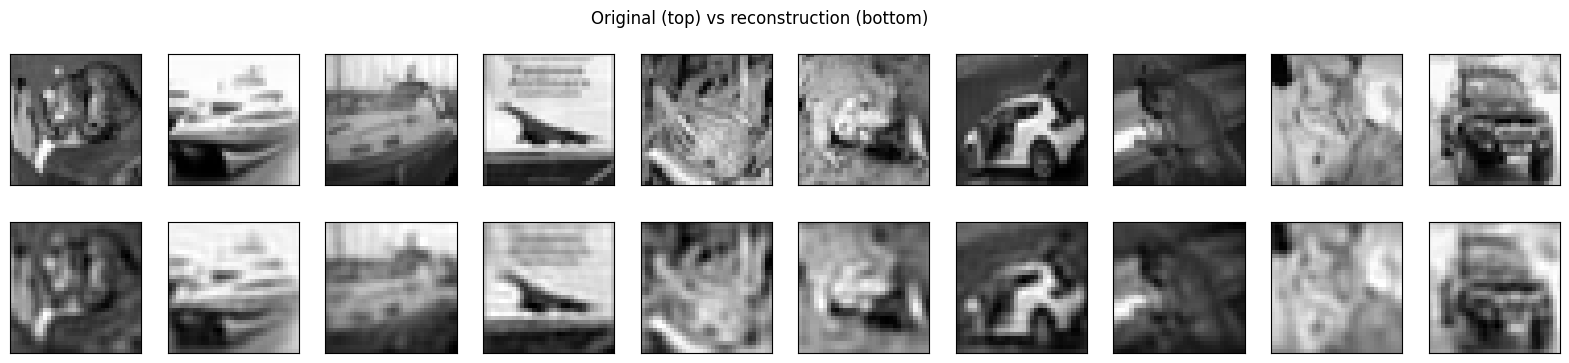

In [ ]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below.

`%STARTEXT`

**ANSWER**:

Increasing ENCODING_DIM allows us to capture more **detailed information** from the original data, but also increases the **computational requirements**. The larger the dimensionality, the more memory and processing power are needed to store and manipulate the data. This can become a challenge, especially in resource-constrained environments like Colab.

Reducing ENCODING_DIM too much leads to **information loss**. The encoded representation may not capture all the relevant features or details, potentially impacting model performance.

In this case, since the flattened images have a dimension of 1024 (32x32), setting ENCODING_DIM equal to 1024 ensures that no information loss occurs during the dimensionality reduction process.

Generally, we are making a trade-off - **we want to choose the smallest ENCODING_DIM that still retains most of the relevant information and provides satisfactory performance**.

`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [12]:
class Auto_Encoder(nn.Module):
  
  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))
    
      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer
    
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

**[TO COMPLETE]** Check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition. 

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [13]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    
    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.85973823 ---------------- Val_Acc: Val_Loss: 0.24442776
epoch: 2 -> Loss: 0.18487254 ---------------- Val_Acc: Val_Loss: 0.14478506
epoch: 3 -> Loss: 0.11793300 ---------------- Val_Acc: Val_Loss: 0.09937088
epoch: 4 -> Loss: 0.08399171 ---------------- Val_Acc: Val_Loss: 0.07354122
epoch: 5 -> Loss: 0.06375296 ---------------- Val_Acc: Val_Loss: 0.05775487
epoch: 6 -> Loss: 0.05062554 ---------------- Val_Acc: Val_Loss: 0.04660617
epoch: 7 -> Loss: 0.04154241 ---------------- Val_Acc: Val_Loss: 0.04003130
epoch: 8 -> Loss: 0.03478155 ---------------- Val_Acc: Val_Loss: 0.03565661
epoch: 9 -> Loss: 0.02987861 ---------------- Val_Acc: Val_Loss: 0.02875285
epoch: 10 -> Loss: 0.02576530 ---------------- Val_Acc: Val_Loss: 0.02597529
epoch: 11 -> Loss: 0.02257221 ---------------- Val_Acc: Val_Loss: 0.02324913
epoch: 12 -> Loss: 0.02020217 ---------------- Val_Acc: Val_Loss: 0.01983039
epoch: 13 -> Loss: 0.01827259 ---------------- Val_Acc: Val_Loss: 0.01807123
epoch: 1

In [14]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

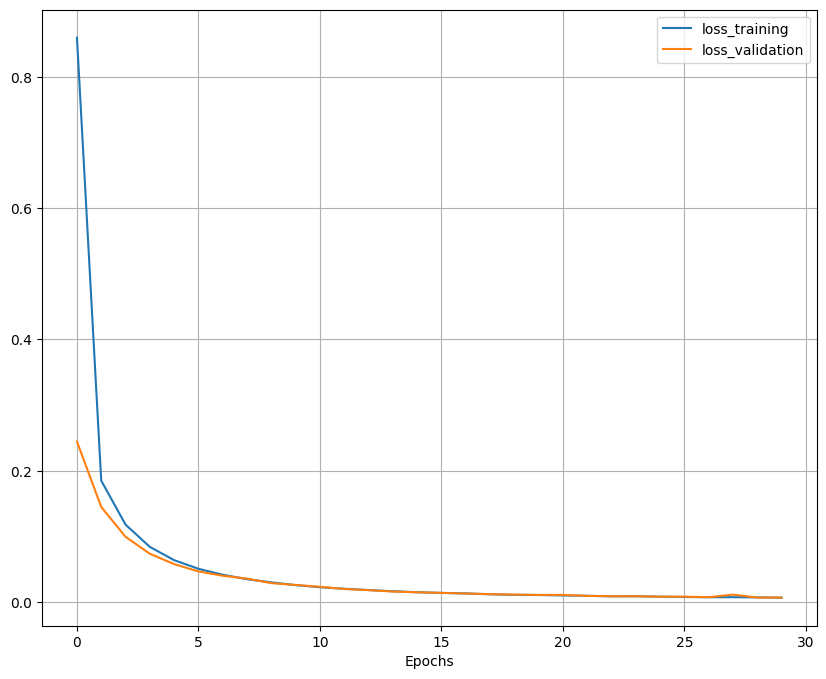

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [15]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [ ]:
test(Shallow_AE)

Test Loss: 0.00685906


In [16]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

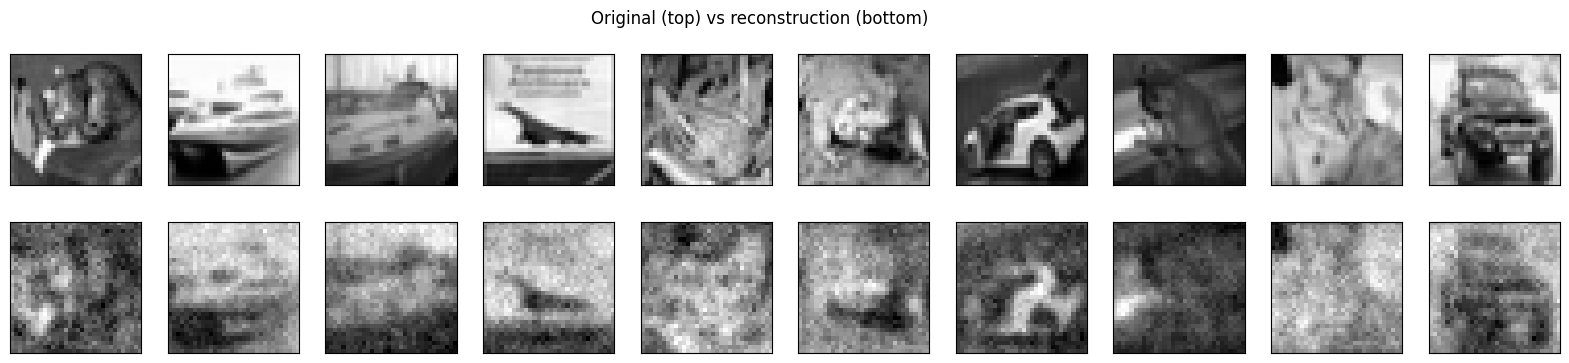

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:

The results obtained with shallow linear autoencoder are **similar** in relation to the ones obtained by the SVD decomposition.

A shallow (one-layer) autoencoder linearly maps the data to a low-dimensional latent space, applies a (usually non-linear) activation function, and projects the result back to the original high-dimensional space so as to minimize reconstruction error.

However, since we are using:

    ACT_FUN = 'linear'
    criterion = torch.nn.MSELoss()

the functionality that we are left with is what a SVD does. 

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30
# END

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.03864314 ---------------- Val_Acc: Val_Loss: 0.02486496
epoch: 2 -> Loss: 0.02099307 ---------------- Val_Acc: Val_Loss: 0.01734272
epoch: 3 -> Loss: 0.01638981 ---------------- Val_Acc: Val_Loss: 0.02433543
epoch: 4 -> Loss: 0.01477144 ---------------- Val_Acc: Val_Loss: 0.01244834
epoch: 5 -> Loss: 0.01222115 ---------------- Val_Acc: Val_Loss: 0.01126062
epoch: 6 -> Loss: 0.01124107 ---------------- Val_Acc: Val_Loss: 0.01036447
epoch: 7 -> Loss: 0.01034477 ---------------- Val_Acc: Val_Loss: 0.00951528
epoch: 8 -> Loss: 0.00995825 ---------------- Val_Acc: Val_Loss: 0.00966011
epoch: 9 -> Loss: 0.00912600 ---------------- Val_Acc: Val_Loss: 0.00921883
epoch: 10 -> Loss: 0.00886501 ---------------- Val_Acc: Val_Loss: 0.00830993
epoch: 11 -> Loss: 0.00833908 ---------------- Val_Acc: Val_Loss: 0.00872249
epoch: 12 -> Loss: 0.00827563 ---------------- Val_Acc: Val_Loss: 0.00773008
epoch: 13 -> Loss: 0.00797130 ---------------- Val_Acc: Val_Loss: 0.00874965
epoch: 1

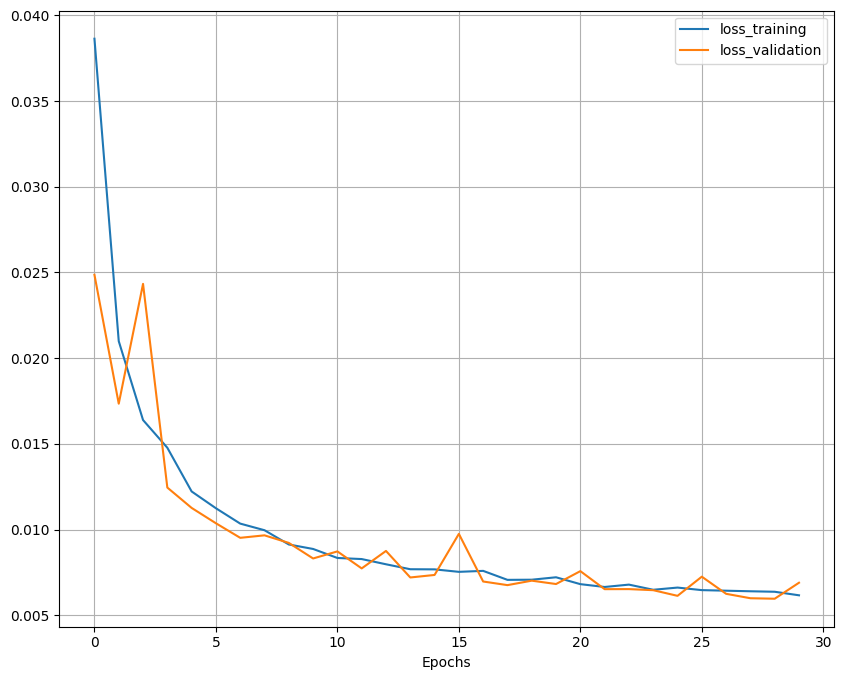

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00688200


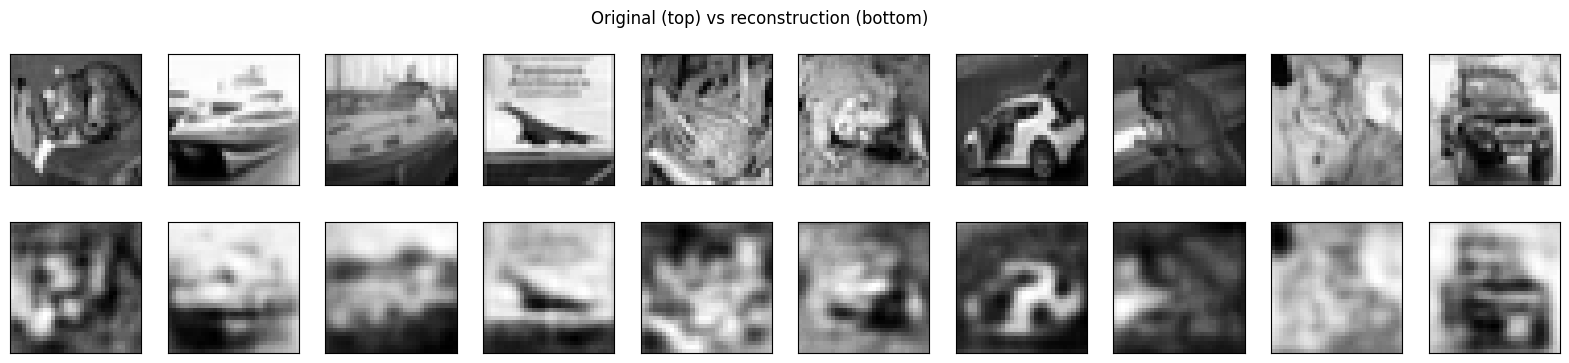

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**:

- Sigmoid

  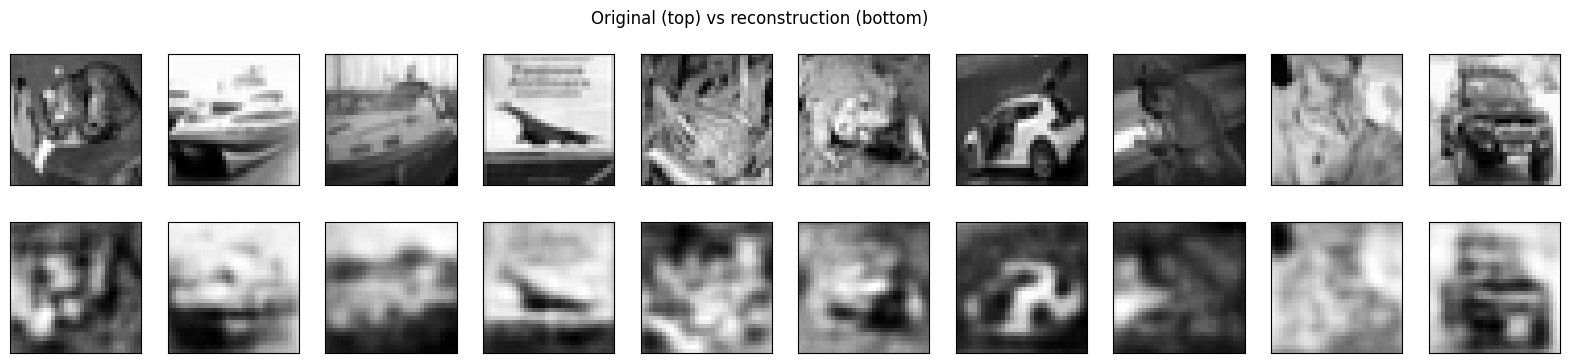


- Tanh

  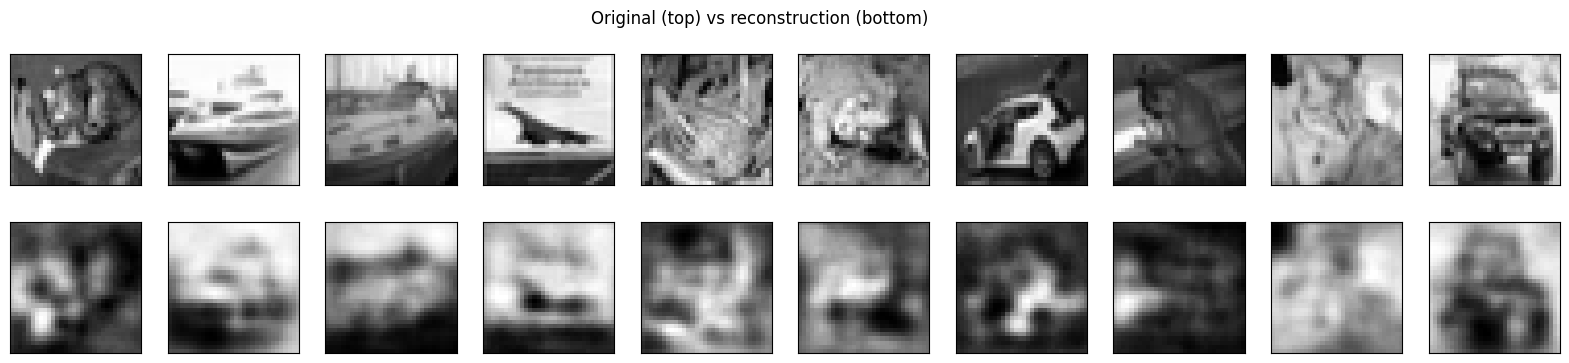



- Leaky ReLU

  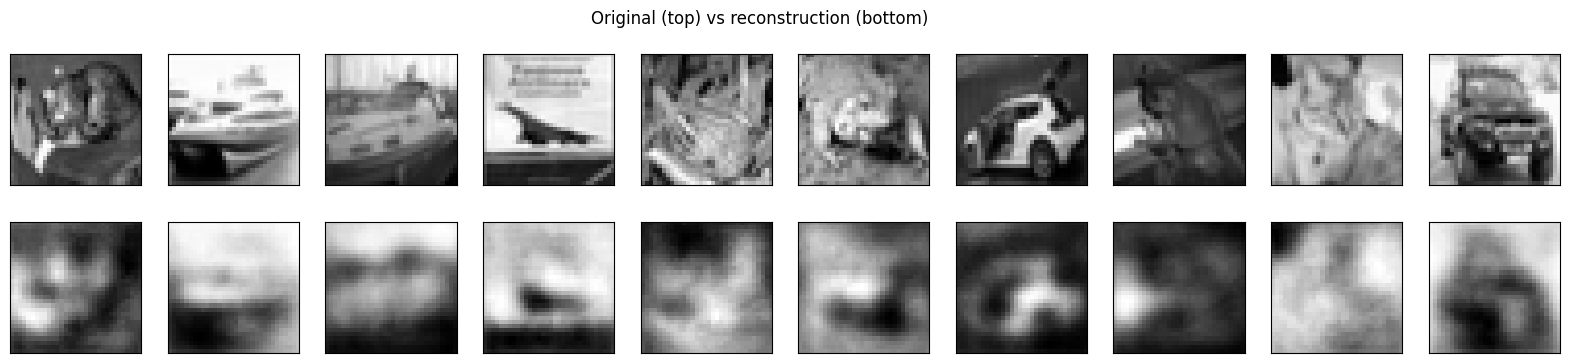


- ReLU:

  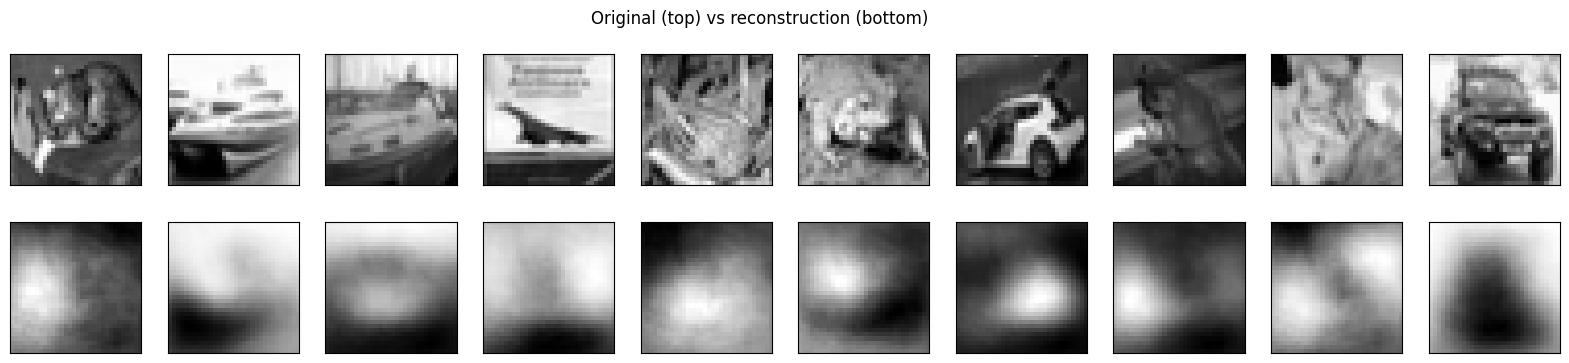


**Discussion:**

From the reconstruction results shown above, we can notice that **ReLU performed the worst**. The ReLU non-linear activation function outputs 0 for any negative input, and the original input for any positive input. This can be a problem for image reconstruction tasks, because it can lead to **loss of information**. For example, if an image contains a lot of small details, these details may be lost when they are passed through a ReLU activation function.

From all of the non-linear activation functions I've tested, **Sigmoid and Tanh performed the best**. They are more "gentle" than ReLU, meaning that they are less likely to lose information when they are applied to images. In addition, sigmoid and tanh can help to preserve the **contrast** in images, which can improve the quality of the reconstructions. And this is noticeable in the shown outputs from the reconstruction.

Leaky RELU is a variation of RELU that addresses some of the problems with RELU. It our case, it resulted in a smaller information loss. The general shape of the objects is present, but many important details are lost.

**Shallow AutoEncoder: Linear vs Non-linear activation function**

*The Shallow Linear Autoencoder performed much better than the non-linear ones.*

The linear AutoEncoder essentially is trying to find a linear combination of the input features that can be used to reconstruct the original image. This is a relatively simple task, and due to their simplicity to train, linear autoencoders typically perform it very well. On the other side, **non-linear autoencoders are more complex, and therefore more difficult to train**. If not tuned properly they may not be able to capture all of the important features of the data, which can lead to worse reconstruction results. More experiments with different activation functions and training parameters are needed in order to find a good solution. However, if we need to capture more complex features of the data, we need to resort to non-linear autoencoders.


`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [IN_DIM, int(IN_DIM/2), int(IN_DIM/4)]
DEC_LAYERS = [int(IN_DIM/4), int(IN_DIM/2)]
ACT_FUN = 'tanh'
lr = 0.001
epochs = 30
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 1024]               1,049,600
│    └─Linear: 2-2                       [512, 512]                524,800
│    └─Linear: 2-3                       [512, 256]                131,328
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 256]                65,792
│    └─Linear: 2-5                       [512, 512]                131,584
│    └─Linear: 2-6                       [512, 1024]               525,312
Total params: 2,428,416
Trainable params: 2,428,416
Non-trainable params: 0
Total mult-adds (G): 1.24
Input size (MB): 2.10
Forward/backward pass size (MB): 14.68
Params size (MB): 9.71
Estimated Total Size (MB): 26.49

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04636253 ---------------- Val_Acc: Val_Loss: 0.03009897
epoch: 2 -> Loss: 0.02738009 ---------------- Val_Acc: Val_Loss: 0.02926924
epoch: 3 -> Loss: 0.02345742 ---------------- Val_Acc: Val_Loss: 0.02141823
epoch: 4 -> Loss: 0.02116911 ---------------- Val_Acc: Val_Loss: 0.01972815
epoch: 5 -> Loss: 0.01968825 ---------------- Val_Acc: Val_Loss: 0.01957549
epoch: 6 -> Loss: 0.01860437 ---------------- Val_Acc: Val_Loss: 0.01752036
epoch: 7 -> Loss: 0.01789397 ---------------- Val_Acc: Val_Loss: 0.01710543
epoch: 8 -> Loss: 0.01726331 ---------------- Val_Acc: Val_Loss: 0.01685525
epoch: 9 -> Loss: 0.01696865 ---------------- Val_Acc: Val_Loss: 0.01650199
epoch: 10 -> Loss: 0.01640960 ---------------- Val_Acc: Val_Loss: 0.01581394
epoch: 11 -> Loss: 0.01648428 ---------------- Val_Acc: Val_Loss: 0.01613662
epoch: 12 -> Loss: 0.01576298 ---------------- Val_Acc: Val_Loss: 0.01510239
epoch: 13 -> Loss: 0.01580589 ---------------- Val_Acc: Val_Loss: 0.01476265
epoch: 1

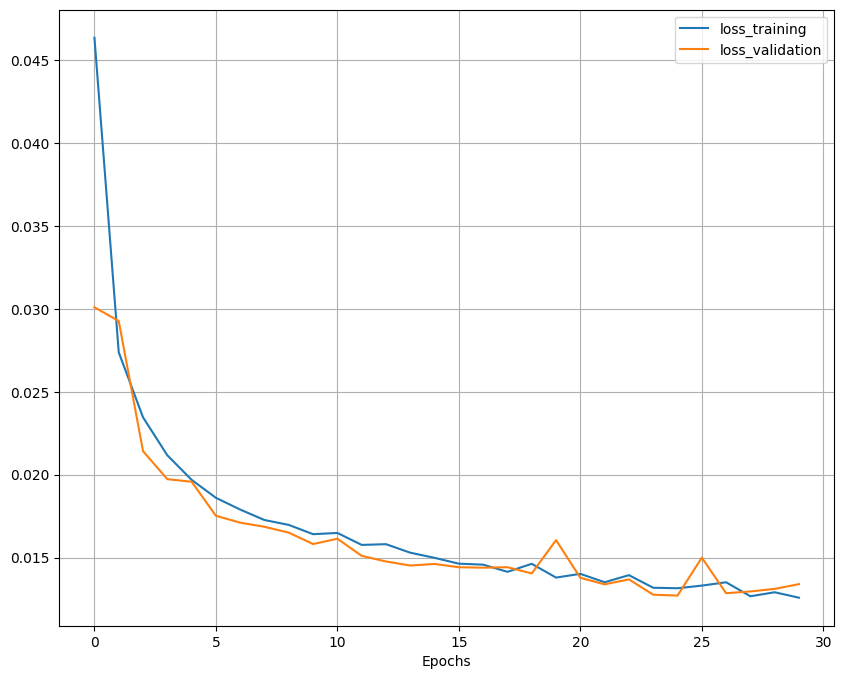

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

Test Loss: 0.01349334


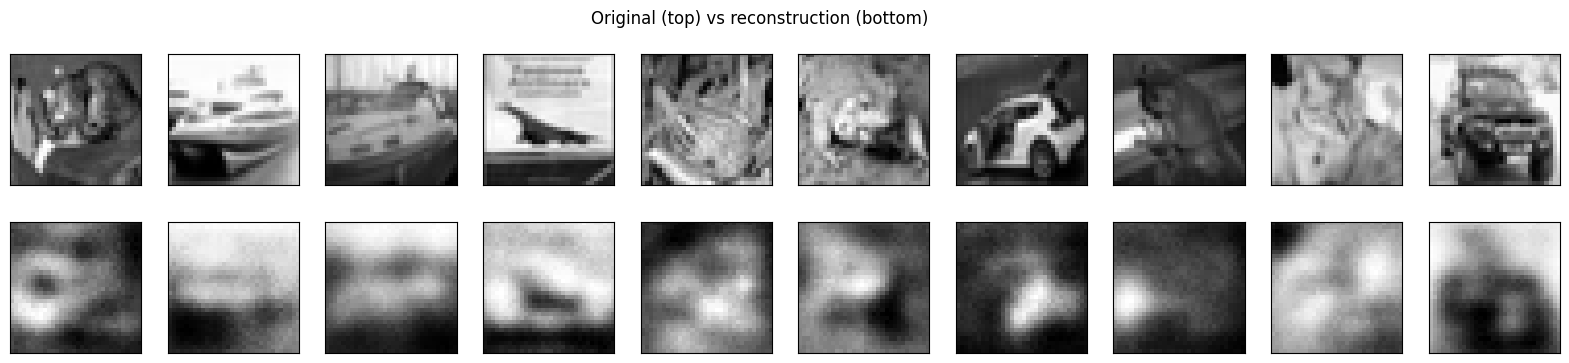

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**:

I started simple: I kept the learning rate and the number of epochs fixed (0.005 and 30), and tried different model architectures, varying the dimensions of the Encoder and Decoder. For all of them, I experimented with 'tanh', 'leaky_relu' and 'relu' as activation functions. My reasoning was that 'sigmoid' would introduce the problem of vanishing gradient, 'linear' wouldn't be able to capture complex patterns, while 'relu' even though it didn't perform well before, it's usually very good choice for deep architectures.

Some of the models I tried were:

* ENC_LAYERS = [512,256,128]; DEC_LAYERS = [256,512]; ACT_FUN = 'relu'    

  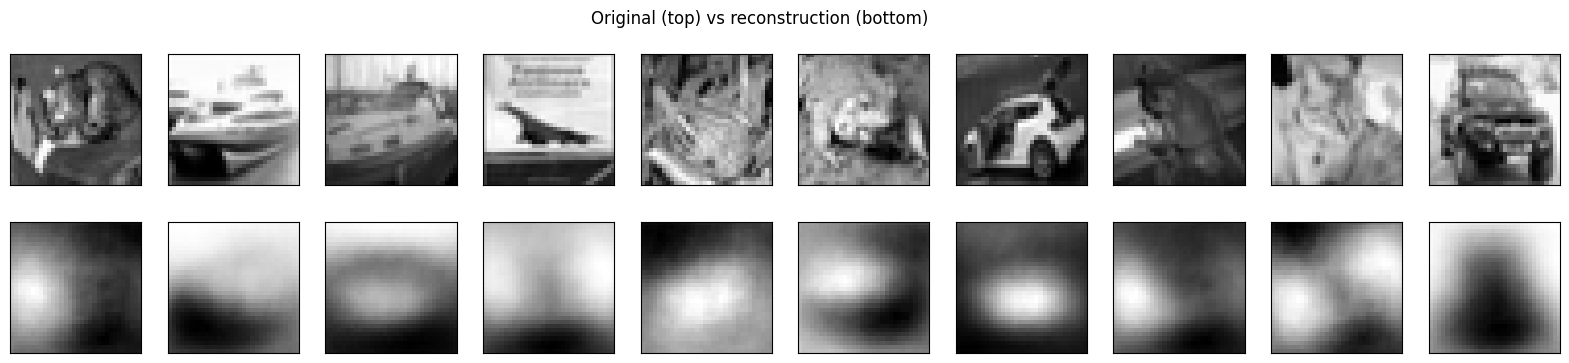

* ENC_LAYERS = [768, 384, 192]; DEC_LAYERS = [192, 384]; ACT_FUN = 'relu'

  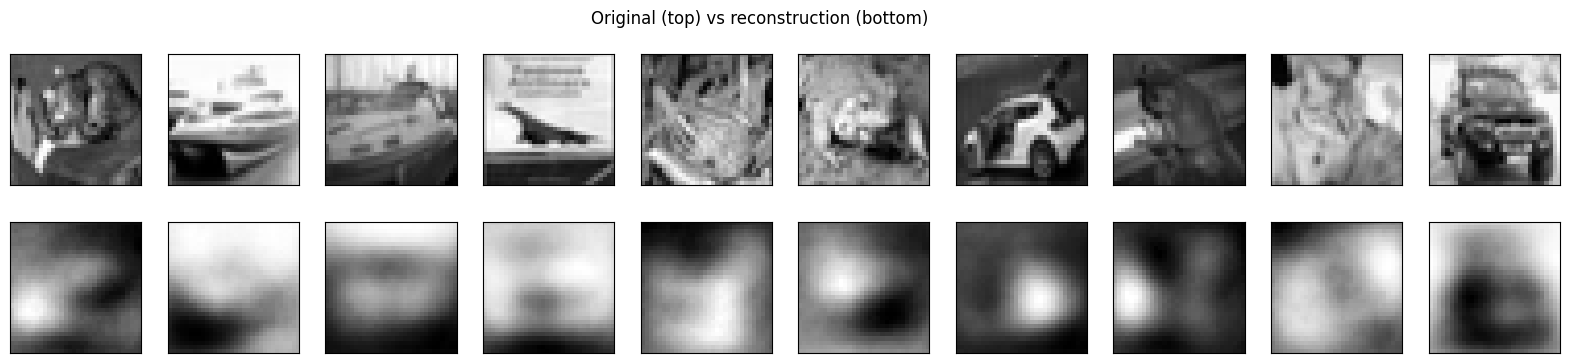


As we can see this initial experimentation didn't yield good results. Most of the reconstructions looked bad, i.e. had a lot of information loss. They could be used just for localizing objects in an image.

However, there was still some difference between the models. I came to conclusion that models for which the dimension of the first layer of the encoder was larger, performed better. Our input is of size 1024, so I didn't go above that.

I choose the following configuration as the best performing one: ENC_LAYERS = [1024, 512, 256], DEC_LAYERS = [256, 512], ACT_FUN = 'tanh'. And continued to try other values for our learning rate, to see its impact on the reconstruction quality. I tried: 0.005, 0.003, 0.001, 0.0001.

* ENC_LAYERS = [1024, 512, 256]; DEC_LAYERS = [256, 512]; ACT_FUN = 'tanh'; lr = 0.001

  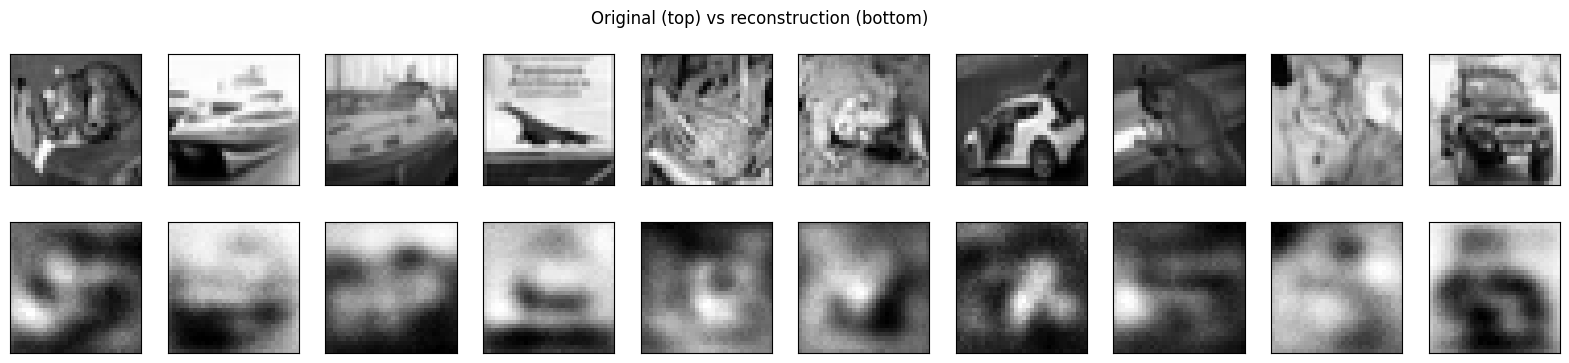

0.001 gave the best results. So, the final step was increasing the number of epochs, and "hoping" that would give us good reconstruction results as we want.

* ENC_LAYERS = [1024, 512, 256]; DEC_LAYERS = [256, 512]; ACT_FUN = 'tanh'; lr = 0.001; epochs = 40

  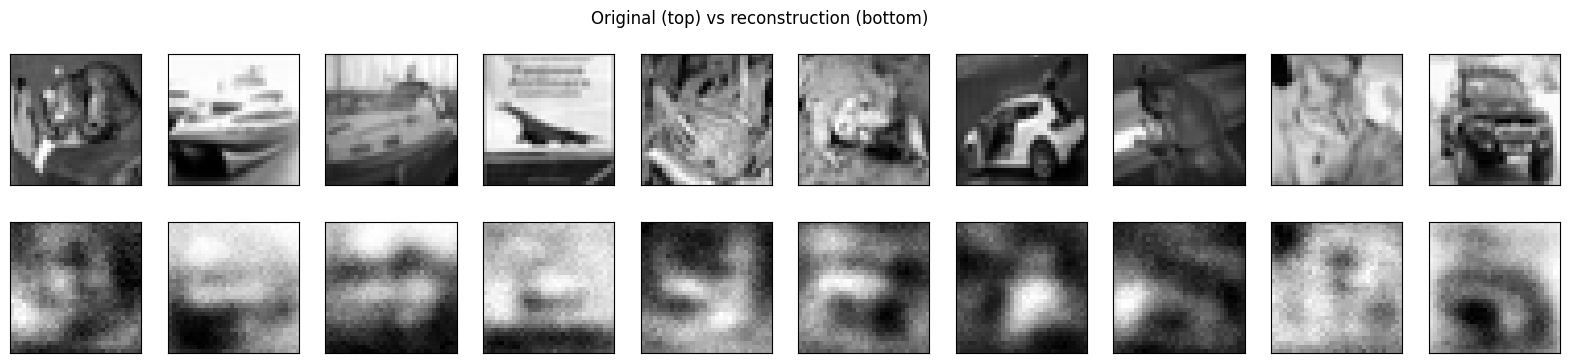

Whether the above result obtained by increasing the number of epochs is better is debatable. In my opinion, in this case it didn't yield better results. But for other configurations I tried, it definitely helped.

`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

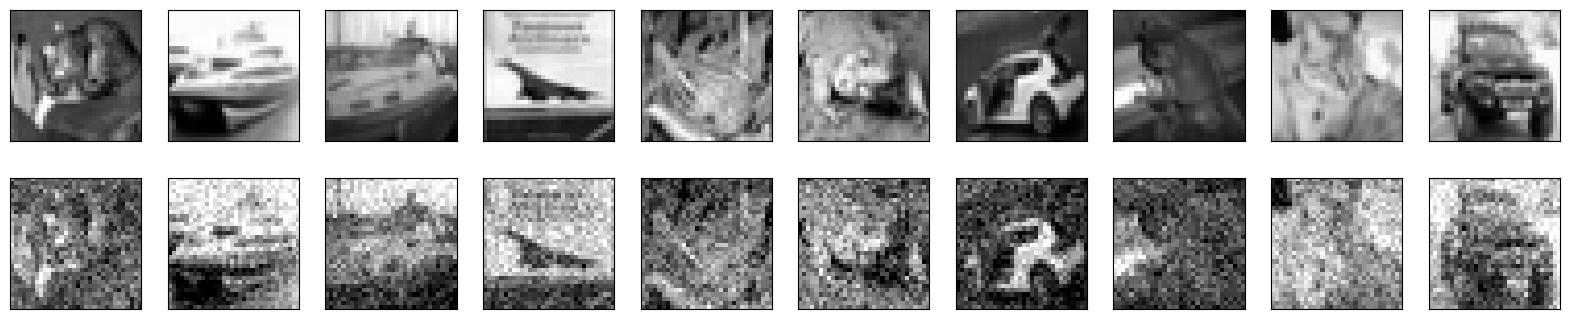

In [31]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [17]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.001
epochs = 30
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [19]:
start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True #[TO COMPLETE]
                             )

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04887595 ---------------- Val_Acc: Val_Loss: 0.03751500
epoch: 2 -> Loss: 0.02967292 ---------------- Val_Acc: Val_Loss: 0.02372848
epoch: 3 -> Loss: 0.02048545 ---------------- Val_Acc: Val_Loss: 0.01830511
epoch: 4 -> Loss: 0.01682583 ---------------- Val_Acc: Val_Loss: 0.01570869
epoch: 5 -> Loss: 0.01477289 ---------------- Val_Acc: Val_Loss: 0.01401068
epoch: 6 -> Loss: 0.01343231 ---------------- Val_Acc: Val_Loss: 0.01289677
epoch: 7 -> Loss: 0.01239907 ---------------- Val_Acc: Val_Loss: 0.01198554
epoch: 8 -> Loss: 0.01163786 ---------------- Val_Acc: Val_Loss: 0.01129947
epoch: 9 -> Loss: 0.01098028 ---------------- Val_Acc: Val_Loss: 0.01071699
epoch: 10 -> Loss: 0.01045343 ---------------- Val_Acc: Val_Loss: 0.01042091
epoch: 11 -> Loss: 0.01002410 ---------------- Val_Acc: Val_Loss: 0.01010009
epoch: 12 -> Loss: 0.00968426 ---------------- Val_Acc: Val_Loss: 0.00953205
epoch: 13 -> Loss: 0.00928373 ---------------- Val_Acc: Val_Loss: 0.00951557
epoch: 1

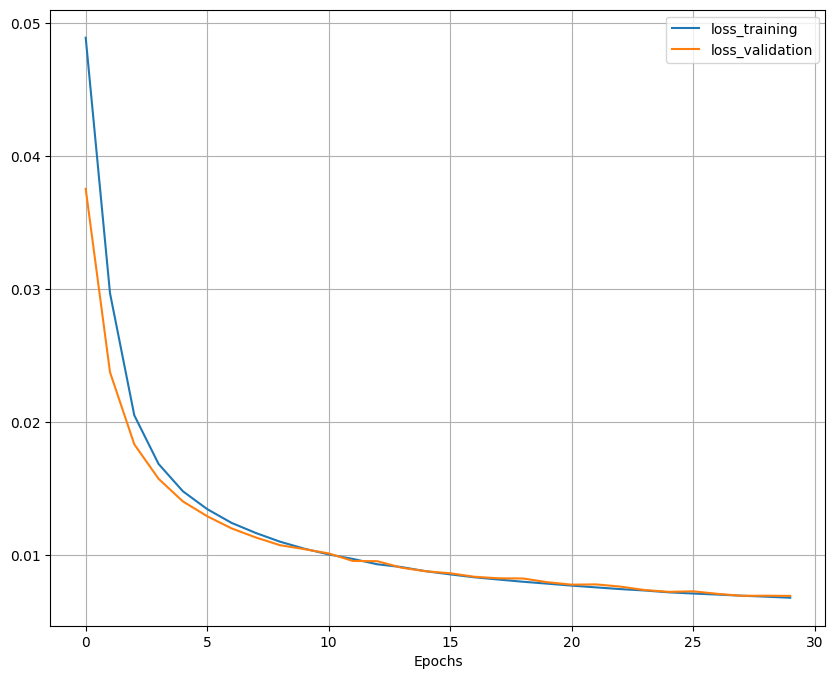

In [20]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [21]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00688760


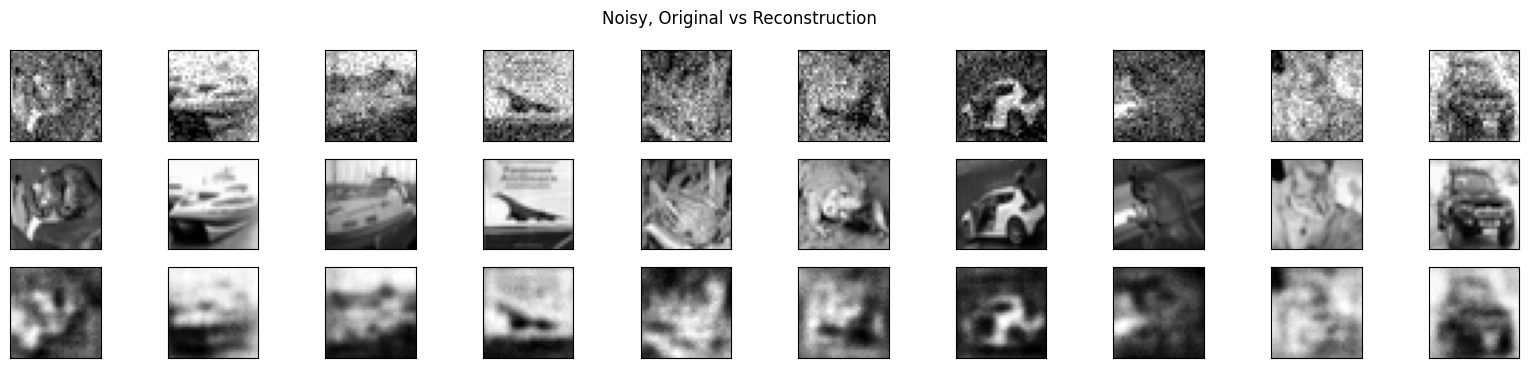

In [22]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`

**ANSWER**:

In all the models I experimented with, I kept the following hyperparameters fixed:

    IN_DIM = x_train.shape[-1]
    ENC_LAYERS = [256]
    DEC_LAYERS = [] 
    epochs = 30

During my observations, I focused on the effects of two hyperparameters: ACT_FUN and lr.

* ACT_FUN = 'tanh'; lr = 0.005  

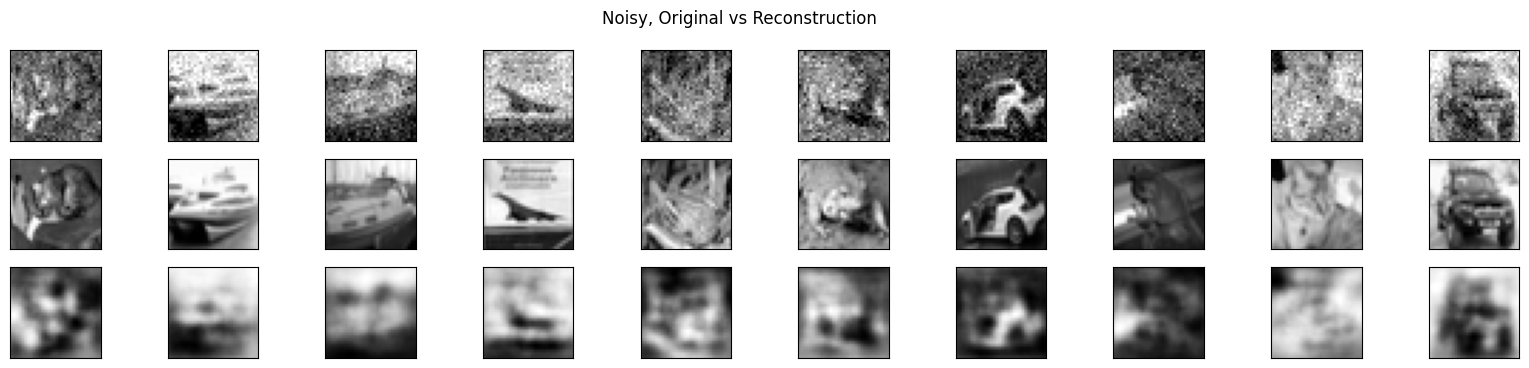


I experimented with the other activation functions as well, but the results were similar as the one above.

The most crucial factor that significantly improved the results was reducing the learning rate. **By lowering the learning rate, I was able to achieve the best performance in the denoising task.**

*  ACT_FUN = 'sigmoid'; lr = 0.001

  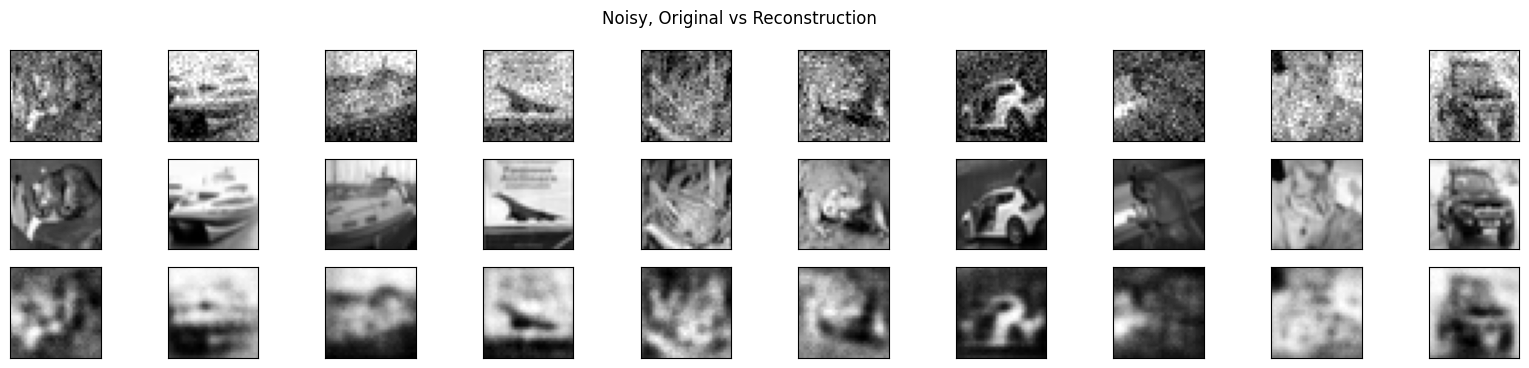


Finally, I wanted to evaluate the network's ability to denoise images with higher levels of noise. The images below are the results for noise_factor = 0.5. The input images injected with noise appear as random pixels to the human eye. But as we can see, **the reconstructions generated by the network retain some level of usefulness.**

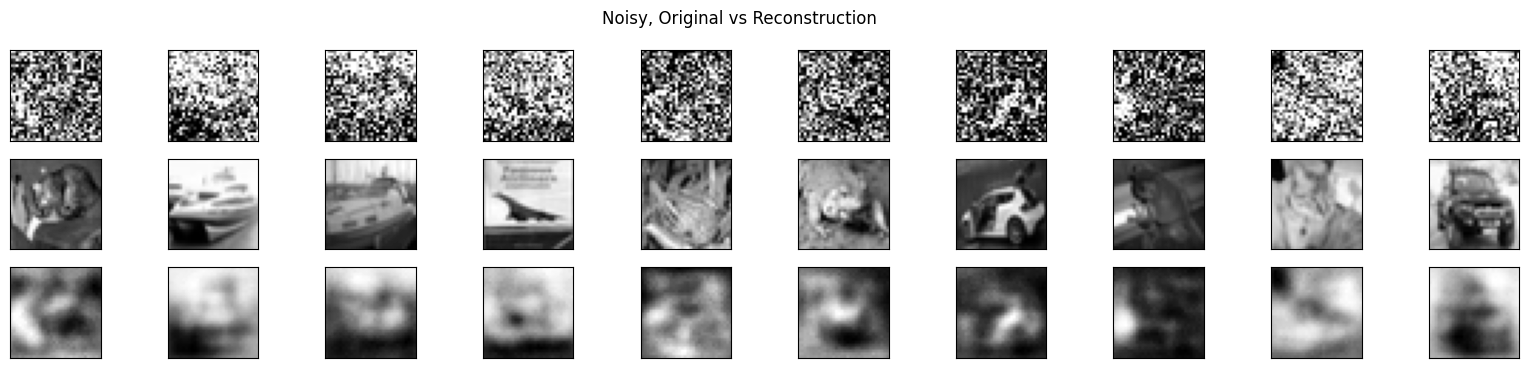

`%ENDTEXT`